<a href="https://colab.research.google.com/github/tak34/crypto_val_bybit/blob/main/val5_2_triple_ballier_FE2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# url = 'https://launchpad.net/~mario-mariomedina/+archive/ubuntu/talib/+files'
# ext = '0.4.0-oneiric1_amd64.deb -qO'
# !wget $url/libta-lib0_$ext libta.deb
# !wget $url/ta-lib0-dev_$ext ta.deb
# !dpkg -i libta.deb ta.deb
# !pip install ta-lib

In [2]:
!pip install wandb

In [3]:
# !pip uninstall lightgbm --yes
# !pip install lightgbm \
#     --no-binary lightgbm \
#     --no-cache lightgbm \
#     --config-settings=cmake.define.USE_CUDA=ON

In [4]:
import lightgbm as lgb
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
import numpy as np
import pandas as pd
import seaborn as sns
# import talib
import datetime as dt
from pathlib import Path
import warnings
import os
import random
from sklearn.metrics import mean_squared_error
from tqdm.notebook import tqdm
import numba
from sklearn. preprocessing import QuantileTransformer as QT
from sklearn. preprocessing import PowerTransformer
from sklearn.metrics import confusion_matrix
from sklearn.metrics import f1_score
from scipy import stats
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import wandb

# plt.rcParams['font.family'] = "MS Gothic"
warnings.simplefilter('ignore')

In [5]:
def fix_all_seeds(seed):
    np.random.seed(seed)
    random.seed(seed)
    os.environ["PYTHONHASHSEED"] = str(seed)

fix_all_seeds(0)

In [6]:
DATA_PATH = "/content/drive/MyDrive/crypto_backtest/Bybit/proc/20240309_val_result/FE2_price_features.pkl"
SAVE = True
SAVE_DIR = Path("/content/drive/MyDrive/crypto_backtest/Bybit/proc/20240316_val_result")
SAVE_FILENAME_FEATURES = "val5-2_df_train_val"
SAVE_FILENAME_RESULTS = "val5-2_df_results"

In [7]:
wandb.login()

wandb: Currently logged in as: trira7503. Use `wandb login --relogin` to force relogin


True

In [8]:
wandb.init(
    project="crypto_bybit",
    name="val5-2_triple_ballier"
)

# データ読み込み・前処理

In [9]:
df_train_val = pd.read_pickle(DATA_PATH)
df_train_val = df_train_val[(df_train_val.index<=dt.datetime(2023, 11, 1))]
df_train_val.head()

,op,hi,lo,cl,volume,NATR_24,buy_entry_price,sell_entry_price,buy_exit_price,buy_losscut_price,...,minute,relative_volatility,return_,return_16,return_4,return_8,volatility_2w,volatility_6h,y,time_count
dt,,,,,,,,,,,,,,,,,,,,,
2020-03-25 10:45:00,6500.0,6591.5,6500.0,6591.5,0.002,NaN,6578.32,6604.68,6657.42,6525.58,...,45,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0
2020-03-25 11:00:00,6591.5,6622.5,6585.5,6590.5,37.803,NaN,6577.32,6603.68,6656.40,6524.60,...,0,NaN,0.999848,NaN,NaN,NaN,NaN,NaN,0.0,1
2020-03-25 11:15:00,6590.5,6628.5,6588.5,6618.0,141.338,NaN,6604.76,6631.24,6684.18,6551.82,...,15,NaN,1.004173,NaN,NaN,NaN,NaN,NaN,0.0,2
2020-03-25 11:30:00,6618.0,6618.0,6457.5,6499.5,120.703,NaN,6486.50,6512.50,6716.31,6282.69,...,30,NaN,0.982094,NaN,NaN,NaN,NaN,NaN,2.0,3
2020-03-25 11:45:00,6499.5,6527.5,6481.5,6511.5,139.029,NaN,6498.48,6524.52,6728.34,6294.66,...,45,NaN,1.001846,NaN,0.987863,NaN,NaN,NaN,2.0,4


In [10]:
df_train_val.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 126294 entries, 2020-03-25 10:45:00 to 2023-11-01 00:00:00
Data columns (total 43 columns):
 #   Column               Non-Null Count   Dtype  
---  ------               --------------   -----  
 0   op                   126294 non-null  float64
 1   hi                   126294 non-null  float64
 2   lo                   126294 non-null  float64
 3   cl                   126294 non-null  float64
 4   volume               126294 non-null  float64
 5   NATR_24              126270 non-null  float64
 6   buy_entry_price      126294 non-null  float64
 7   sell_entry_price     126294 non-null  float64
 8   buy_exit_price       126294 non-null  float64
 9   buy_losscut_price    126294 non-null  float64
 10  sell_exit_price      126294 non-null  float64
 11  sell_losscut_price   126294 non-null  float64
 12  NATR                 126286 non-null  float64
 13  OI_log_diff_32       113600 non-null  float64
 14  OI_log_diff_672      112960 non-nu

In [11]:
features_binning = [
    "SMA",
    "SMA_28",
    "SMA_96",
    "SMA_672",
    "SMA_pi",
    "SMA_pi28",
    "SMA_pi96",
    "SMA_pi672",
    "SMA_index",
    "SMA_index28",
    "SMA_index96",
    "SMA_index672",
    "return_",
    "return_4",
    "return_8",
    "return_16",
    "NATR",
    "RSI",
    "fr",
    # "oi_per_vol32",
    # "oi_per_vol96",
    # "oi_per_vol672",
    "OI_log_diff_8",
    "OI_log_diff_32",
    "OI_log_diff_96",
    "OI_log_diff_672",
    "log_ret_1day",
    "volatility_6h",
    "volatility_2w",
    "relative_volatility"
]

In [12]:
features = [
    "SMA",
    "SMA_28",
    "SMA_96",
    "SMA_672",
    "SMA_pi",
    "SMA_pi28",
    "SMA_pi96",
    "SMA_pi672",
    "SMA_index",
    "SMA_index28",
    "SMA_index96",
    "SMA_index672",
    "return_",
    "return_4",
    "return_8",
    "return_16",
    "NATR",
    "RSI",
    "hour",
    # "minute",
    "fr",
    # "oi_per_vol32",
    # "oi_per_vol96",
    # "oi_per_vol672",
    "OI_log_diff_8",
    "OI_log_diff_32",
    "OI_log_diff_96",
    "OI_log_diff_672",
    "log_ret_1day",
    "volatility_6h",
    "volatility_2w",
    "relative_volatility"
]

print("特徴量の数：", len(features))

特徴量の数： 28


# Validation

## 関数

In [13]:
def my_purge_kfold2(n, n_splits=6, purge=4*24*10):
    idx = np.arange(n)
    cv = []
    for i in range(n_splits):
        val_start = i * n // (n_splits)
        val_end = (i + 1) * n // (n_splits)
        val_idx = idx[val_start:val_end]
        train_idx = idx[(idx < val_start - purge) | (val_end + purge <= idx)]
        cv.append((
            train_idx,
            val_idx,
        ))
    return cv

In [25]:
# def feval_pearsonr(y_pred, lgb_train):
#     y_true = lgb_train.get_label()
#     return 'pearsonr', stats.pearsonr(y_true, y_pred)[0], True

# def neutralize_pred(df, neut_feats, coef=1):
#     df = df.replace([-np.inf, np.inf], np.nan).fillna(0)
#     df_feat = df[neut_feats].copy()
#     scaler = StandardScaler()
#     scaler.fit(df_feat.iloc[:4*24*60, :])
#     X = scaler.transform(df_feat)
#     lm = LinearRegression()
#     lm.fit(X[:4*24*60, :], df["pred"].values[:4*24*60])
#     df["pred_nt"] = df["pred"] - lm.predict(X) * coef

#     return df["pred_nt"].values

def plot_learning_rate(dict_learning_rate, ylim=None):
    fig, ax = plt.subplots(figsize=(6, 4))
    ax.grid(alpha=0.2)
    for key, value in dict_learning_rate.items():
        x = list(range(len(value)))
        ax.plot(x, value, label=key)
    ax.legend(loc="upper left", bbox_to_anchor=(1, 0.5))
    if ylim:
        ax.set_ylim(ylim)
    plt.show()

def plot_results(results1, results2):
    x_list = [f"cv{i}" for i in range(1, 7)]
    fig = plt.figure(figsize=(14, 4))
    ax = fig.add_subplot(121)
    ax.bar(x=x_list, height=results1, label="F1 Score (Micro)", zorder=10)
    ax.set_ylabel("F1 Score (Micro)")
    ax.set_ylim([0, 0.70])
    ax.grid(zorder=-10)
    ax.legend()
    ax2 = fig.add_subplot(122)
    ax2.bar(x=x_list, height=results2, label="F1 Score (Macro)", color="green", zorder=10)
    ax2.set_ylabel("F1 Score (Macro)")
    ax2.set_ylim([0, 0.70])
    ax2.grid(zorder=-10)
    ax2.legend()
    plt.show()

# from: https://blog.amedama.jp/entry/lightgbm-cv-feature-importance
def plot_importance(fi_df, figsize=(10, 10)):
#     raw_importances = cvbooster.feature_importance(importance_type='gain')
    feature_name = fi_df.features.to_list()
    importance_df = pd.DataFrame(data=fi_df.iloc[:, 1:].values.T,
                             columns=feature_name)
    # 平均値でソートする
    sorted_indices = importance_df.mean(axis=0).sort_values(ascending=False).index
    sorted_importance_df = importance_df.loc[:, sorted_indices]
    # 上位をプロットする
#     PLOT_TOP_N = 40
    plot_cols = sorted_importance_df.columns[:80]
    _, ax = plt.subplots(figsize=figsize)
    ax.grid()
    ax.set_xscale('log')
    ax.set_ylabel('Feature')
    ax.set_xlabel('Importance')
    sns.boxplot(data=sorted_importance_df[plot_cols],
                orient='h',
                ax=ax)
    plt.show()

Fold 0


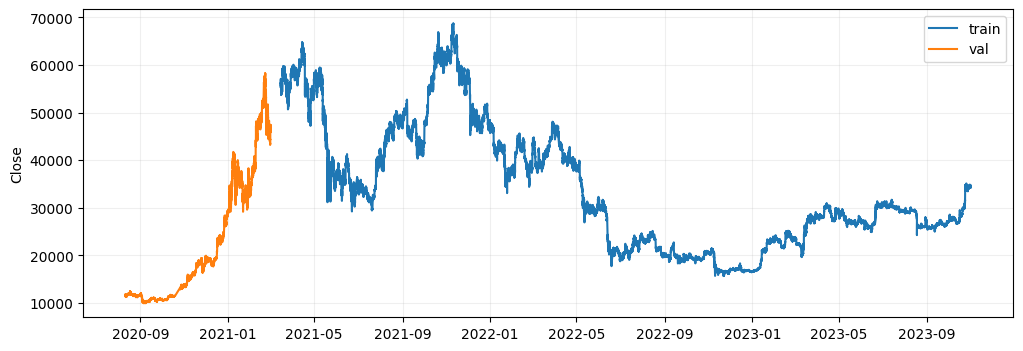

[1000]	valid_0's multi_logloss: 0.763568
[2000]	valid_0's multi_logloss: 0.757057
[3000]	valid_0's multi_logloss: 0.754157
[4000]	valid_0's multi_logloss: 0.752515


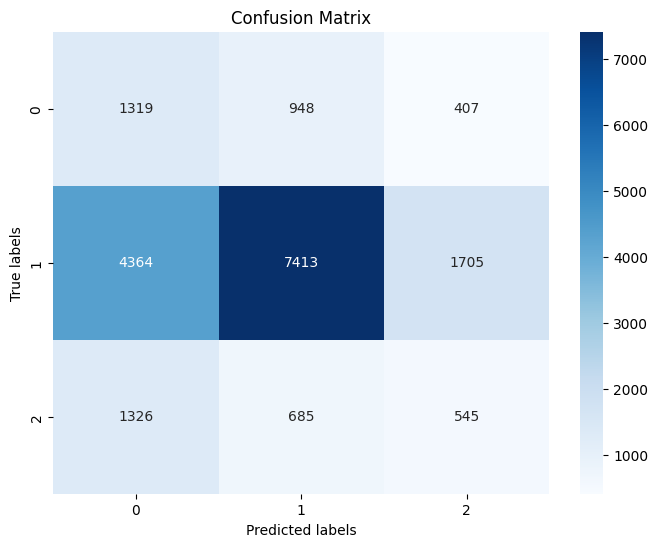

F1スコア (マイクロ平均): 0.496
F1スコア (マクロ平均): 0.380
Fold 1


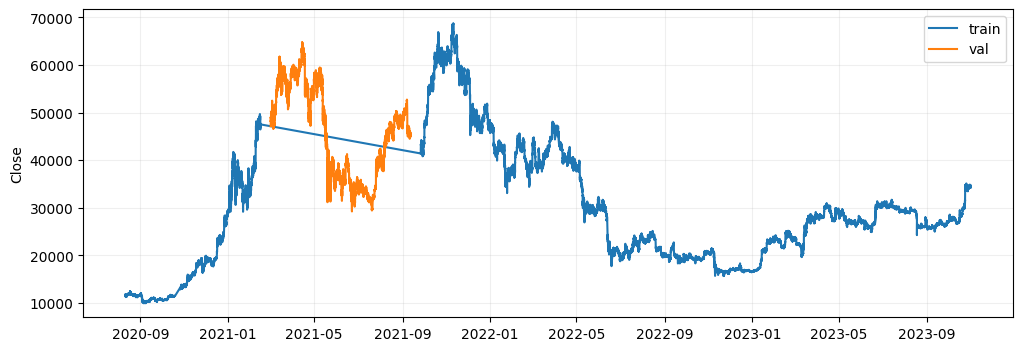

[1000]	valid_0's multi_logloss: 0.766271
[2000]	valid_0's multi_logloss: 0.755788
[3000]	valid_0's multi_logloss: 0.750864
[4000]	valid_0's multi_logloss: 0.748145


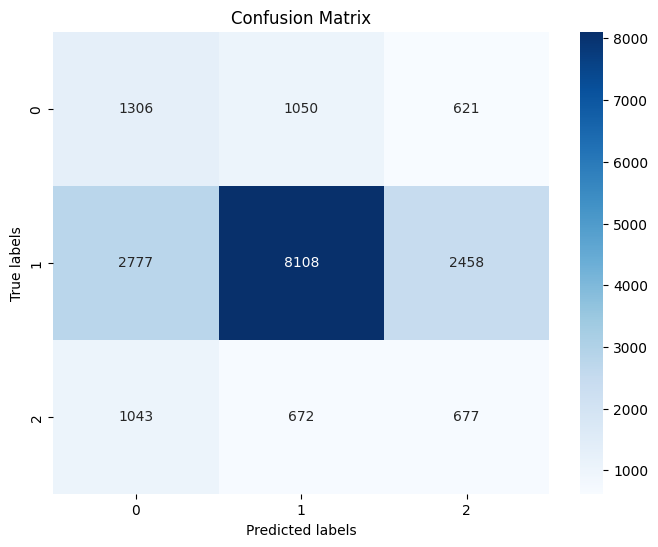

F1スコア (マイクロ平均): 0.539
F1スコア (マクロ平均): 0.414
Fold 2


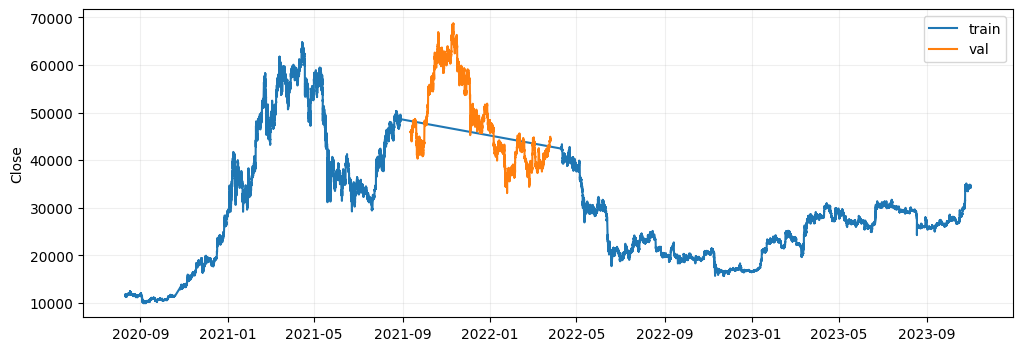

[1000]	valid_0's multi_logloss: 0.823318
[2000]	valid_0's multi_logloss: 0.809262
[3000]	valid_0's multi_logloss: 0.802308
[4000]	valid_0's multi_logloss: 0.798044


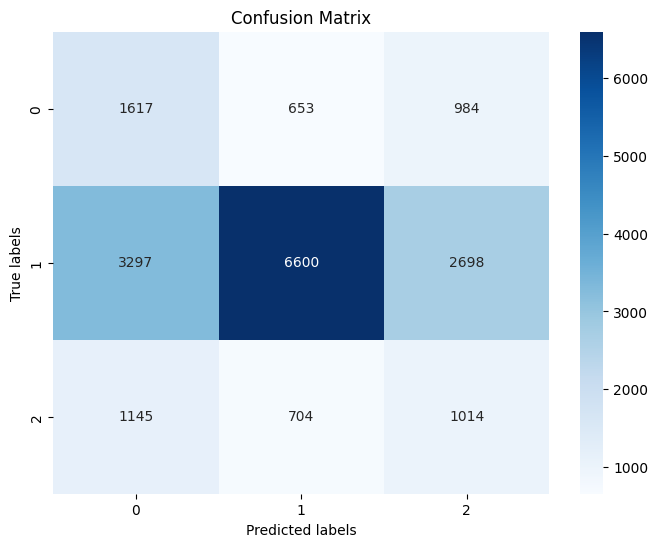

F1スコア (マイクロ平均): 0.493
F1スコア (マクロ平均): 0.419
Fold 3


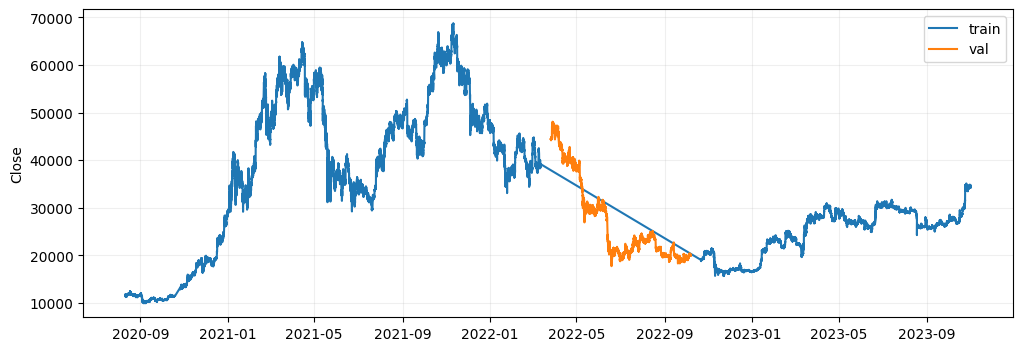

[1000]	valid_0's multi_logloss: 0.793032
[2000]	valid_0's multi_logloss: 0.777072
[3000]	valid_0's multi_logloss: 0.768503
[4000]	valid_0's multi_logloss: 0.763178


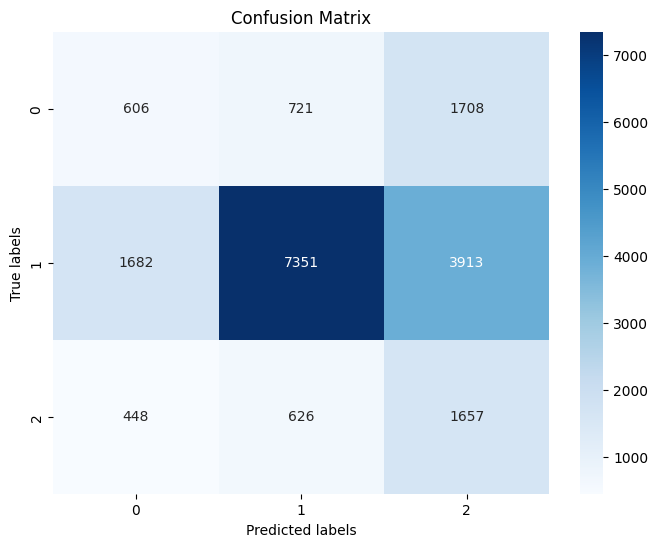

F1スコア (マイクロ平均): 0.514
F1スコア (マクロ平均): 0.407
Fold 4


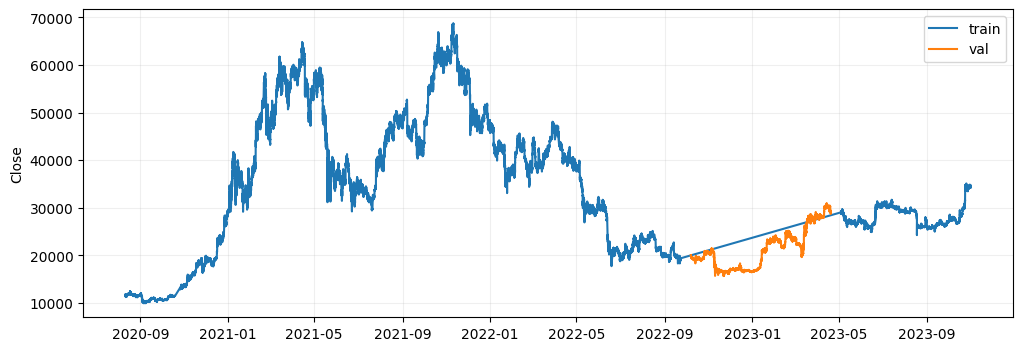

[1000]	valid_0's multi_logloss: 0.766949
[2000]	valid_0's multi_logloss: 0.758055
[3000]	valid_0's multi_logloss: 0.7534
[4000]	valid_0's multi_logloss: 0.75056


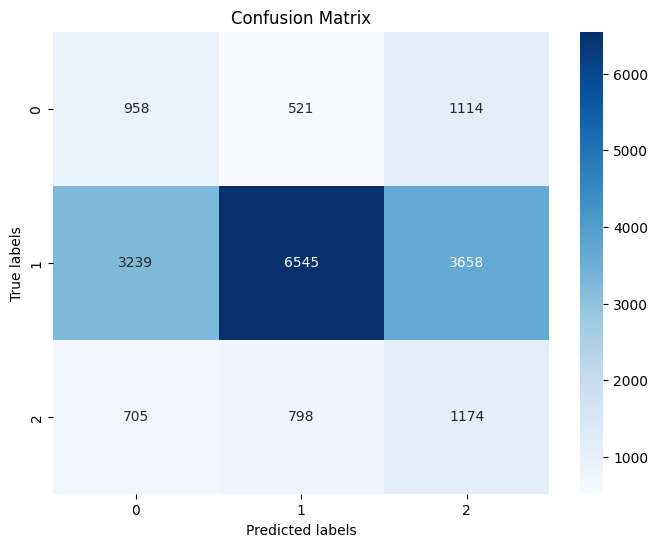

F1スコア (マイクロ平均): 0.464
F1スコア (マクロ平均): 0.381
Fold 5


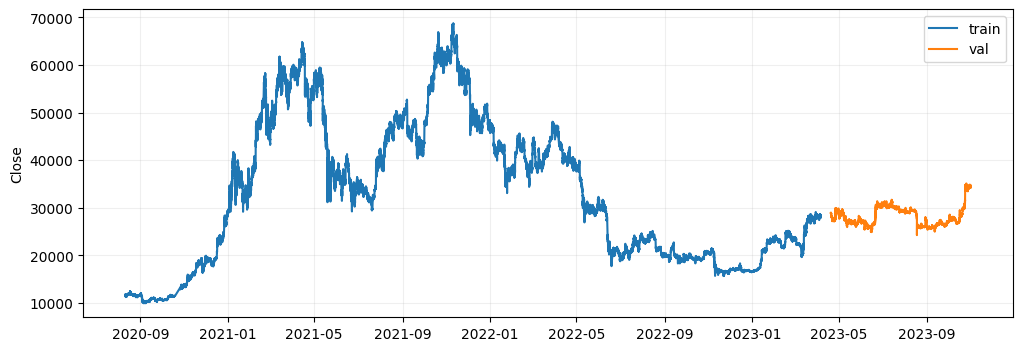

[1000]	valid_0's multi_logloss: 0.732532
[2000]	valid_0's multi_logloss: 0.724767
[3000]	valid_0's multi_logloss: 0.718619
[4000]	valid_0's multi_logloss: 0.713725


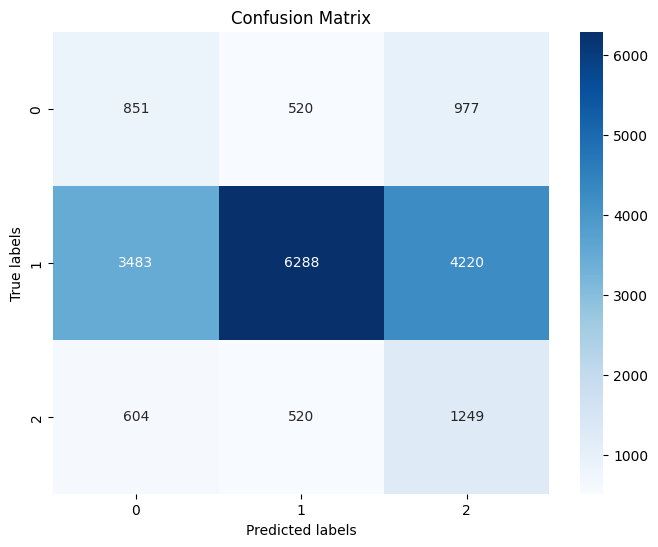

F1スコア (マイクロ平均): 0.448
F1スコア (マクロ平均): 0.369


In [15]:
# https://www.kaggle.com/code1110/gresearch-simple-lgb-starter
def my_cross_val_predict(df, y_name=None, cv=None, params=None, features=None):
    results_corr = []
    results_scorr = []
    dict_learning_rate = {}
    fi_df = pd.DataFrame()
    fi_df['features'] = features
    cols_results = [
        "y_proba1",
        "y_proba2",
        "y_proba3",
        "y_proba1_mod",
        "y_proba2_mod",
        "y_proba3_mod"
    ]
    df_results = pd.DataFrame(np.zeros((len(df), 6)), columns=cols_results)

    scores_f1_micro = []
    scores_f1_macro = []
    cv_all = np.zeros(df.shape[0])
    cv_all[:] = np.nan
    for counter, (train_idx, val_idx) in enumerate(cv):
        print("==="*10)
        print(f"Fold {counter}")
        print("==="*10)
        df_train = df.iloc[train_idx].copy()
        df_val = df.iloc[val_idx].copy()

        # CVの期間と値動き知りたいから簡単に可視化する
        fig, ax = plt.subplots(figsize=(12, 4))
        ax.grid(alpha=0.2)
        ax.plot(df_train.index, df_train["cl"], label="train")
        ax.plot(df_val.index, df_val["cl"], label="val")
        ax.legend()
        ax.set_ylabel("Close")
        plt.show()

        # features
        for feat in features_binning:
            try:
                df_train[feat], bins = pd.qcut(df_train[feat].values, 5, retbins=True, labels=[0, 1, 2, 3, 4])
                bins[0] = -999
                bins[-1] = 999
                df_val[feat] = pd.cut(df_val[feat].values, bins=bins, labels=[0, 1, 2, 3, 4], include_lowest=True)
                df_train[feat].astype("float16")
                df_val[feat].astype("float16")
            except:
                pass

        assert df_val[features_binning].isnull().sum().sum() == 0

        X_train = df_train[features].values
        y_train = df_train[y_name].values
        X_val = df_val[features].values
        y_val = df_val[y_name].values
        y_val_raw = df_val[y_name].values

        # y_trainに含まれる各ビンの割合を算出し、予測結果の補正をする
        coef_y0 = np.sum(y_train == 0) / len(y_train)
        coef_y1 = np.sum(y_train == 1) / len(y_train)
        coef_y2 = np.sum(y_train == 2) / len(y_train)

        train_dataset = lgb.Dataset(X_train,
                                    y_train,
                                    feature_name=features,)
        val_dataset = lgb.Dataset(X_val,
                                  y_val,
                                  feature_name=features,)

        evals_result = {}
        callbacks = [
            lgb.log_evaluation(period=1000),
            # lgb.early_stopping(500),
            lgb.record_evaluation(evals_result)
        ]

        model = lgb.train(params=params,
                          train_set=train_dataset,
                          valid_sets=[val_dataset],
                          callbacks=callbacks)
        y_pred = model.predict(X_val)

        # 予測結果を学習データのbinの割合で補正
        y_pred_mod = y_pred.copy()
        y_pred_mod[:, 0] /= coef_y0
        y_pred_mod[:, 1] /= coef_y1
        y_pred_mod[:, 2] /= coef_y2

        # 補足した予測値で予測のbinを決定
        y_pred_bin = np.argmax(y_pred_mod, axis=1)

        # df_resultsに結果を突っ込んでおく
        df_results.iloc[val_idx, :3] = y_pred
        df_results.iloc[val_idx, 3:] = y_pred_mod

        cv_all[val_idx] = counter

        # 混同行列の計算
        conf_mat = confusion_matrix(y_val, y_pred_bin)

        # ヒートマップの作成
        plt.figure(figsize=(8, 6))
        sns.heatmap(conf_mat, annot=True, fmt='d', cmap='Blues')
        plt.xlabel('Predicted labels')
        plt.ylabel('True labels')
        plt.title('Confusion Matrix')
        plt.show()

        # マイクロ平均でのF1スコア
        f1_micro = f1_score(y_val, y_pred_bin, average='micro')
        scores_f1_micro.append(f1_micro)
        # マクロ平均でのF1スコア
        f1_macro = f1_score(y_val, y_pred_bin, average='macro')
        scores_f1_macro.append(f1_macro)

        print(f'F1スコア (マイクロ平均): {f1_micro:.3f}')
        print(f'F1スコア (マクロ平均): {f1_macro:.3f}')

        fi_df[f"importance_cv{counter}"] = model.feature_importance(importance_type='gain')
        dict_learning_rate[f"fold_{counter}"] = np.array(evals_result['valid_0']['multi_logloss'])
        counter += 1

    # df_relustsにcv番号追加
    df_results['cv'] = cv_all

    return fi_df, df_results, dict_learning_rate, scores_f1_micro, scores_f1_macro

# # 20220507optuna
params = {
    "extra_trees": True,
    'objective': 'multiclass',
    'metric': 'multi_logloss',
    'num_class': 3,
    'boosting_type': 'gbdt',
    'max_depth': 3,
    'n_estimators': 4000,
    'learning_rate': 0.001,
    'colsample_bytree': 0.614591463230662,
    'verbose': -1,
    'n_jobs': -1,
    'seed': 46,
}

df_train_val = df_train_val.dropna()
cv_indicies = my_purge_kfold2(len(df_train_val), purge=4*24*14)

fi_df, df_results, dict_lr, scores_f1_micro, scores_f1_macro = my_cross_val_predict(
    df_train_val.copy(),
    'y',
    cv=cv_indicies,
    params=params,
    features=features,
)

## 結果

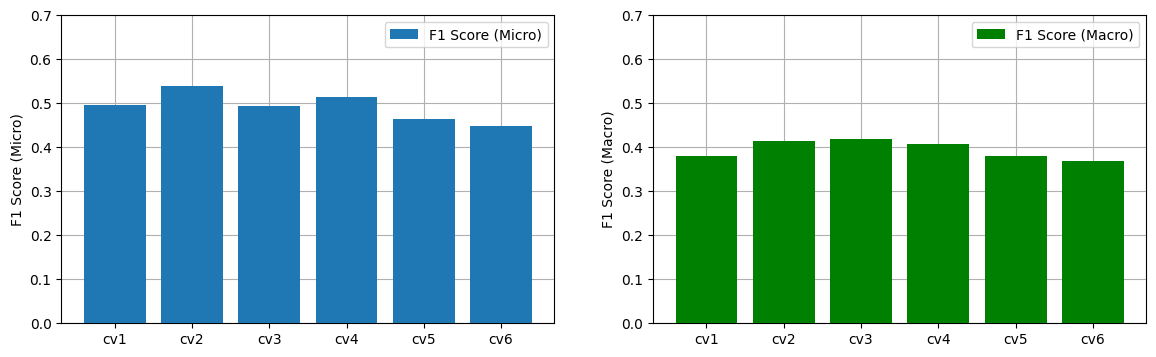

In [26]:
plot_results(scores_f1_micro, scores_f1_macro)

------------------------------
●学習曲線
------------------------------


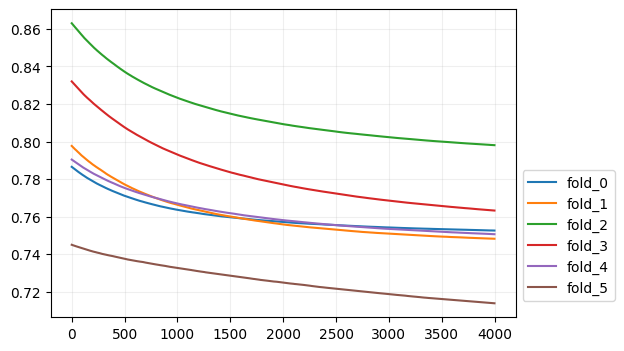

------------------------------
●特徴量重要度
------------------------------


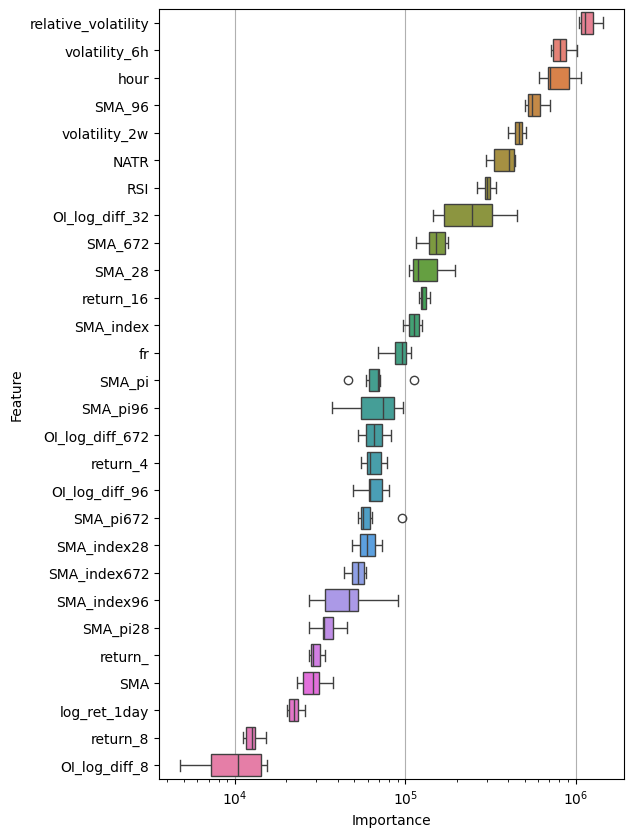

In [17]:
print("---"*10)
print("●学習曲線")
print("---"*10)
plot_learning_rate(dict_lr)
print("---"*10)
print("●特徴量重要度")
print("---"*10)
plot_importance(fi_df, figsize=(6, 10))

In [18]:
# plot_results(results_corr_buy, results_scorr_buy)

In [19]:
# fig = plt.figure(figsize=(8, 6))
# ax1 = fig.add_subplot(211)
# ax1.grid(alpha=0.2)
# ax1.hist(np.clip(df_train_val['y_pred_buy_wa'], -1.5, 1.5), bins=30)
# ax1.set_title("y_pred (buy)")
# ax2 = fig.add_subplot(212)
# ax2.grid(alpha=0.2)
# ax2.hist(np.clip(df_train_val['y_pred_sell_wa'], -1.5, 1.5), bins=30)
# ax2.set_title("y_pred (sell)")
# plt.show()

In [20]:
# corr = stats.spearmanr(df_train_val['y_pred_buy_wa'], df_train_val['y_buy'])[0]
# fig, ax = plt.subplots()
# ax.grid(alpha=0.2)
# ax.scatter(df_train_val['y_pred_buy_wa'], df_train_val['y_buy'], s=2, alpha=0.3)
# ax.set_xlabel("Pred")
# ax.set_ylabel("True")
# # ax.set_xlim([-0.9, 0.9])
# ax.set_ylim([-0.1, 0.1])
# ax.set_title(f"Buy (Corr: {corr:.4f}")
# plt.show()

In [21]:
# corr = stats.spearmanr(df_train_val['y_pred_sell_wa'], df_train_val['y_sell'])[0]
# fig, ax = plt.subplots()
# ax.grid(alpha=0.2)
# ax.scatter(df_train_val['y_pred_sell_wa'], df_train_val['y_sell'], s=2, alpha=0.3)
# ax.set_xlabel("Pred")
# ax.set_ylabel("True")
# # ax.set_xlim([-0.9, 0.9])
# ax.set_ylim([-0.1, 0.1])
# ax.set_title(f"Sell (Corr: {corr:.4f}")
# plt.show()

In [22]:
df_results.describe()

,y_proba1,y_proba2,y_proba3,y_proba1_mod,y_proba2_mod,y_proba3_mod,cv
count,112272.000000,112272.000000,112272.000000,112272.000000,112272.000000,112272.000000,112272.000000
mean,0.151963,0.707300,0.140737,1.014932,0.994420,1.012811,2.500000
std,0.061211,0.112795,0.060298,0.409542,0.158332,0.435128,1.707833
min,0.028495,0.380057,0.017544,0.183129,0.536318,0.127182,0.000000
25%,0.103718,0.624239,0.093138,0.694404,0.879161,0.670625,1.000000
50%,0.145361,0.716308,0.134889,0.970445,1.007642,0.969585,2.500000
75%,0.193458,0.800103,0.183496,1.284308,1.124307,1.318203,4.000000
max,0.372008,0.942622,0.332716,2.528052,1.331524,2.378581,5.000000


In [23]:
if SAVE:
    df_train_val.to_pickle(SAVE_DIR / f"{SAVE_FILENAME_FEATURES}.pkl")
    df_results.to_pickle(SAVE_DIR / f"{SAVE_FILENAME_RESULTS}.pkl")

In [24]:
# wandb.log({
#             "Final_asset": int(df_result["temp_asset"].values[-1]),
#             "Max_DD": df_result['drawdown'].min()*-100,
#             "Entry_order_buy": (df_result["entry_order"]==1).sum(),
#             "Entry_buy": (df_result["entry"]==1).sum(),
#             "Entry_order_sell": (df_result["entry_order"]==-1).sum(),
#             "Entry_sell": (df_result["entry"]==-1).sum(),
#             "Losscut": df_result["losscut"].sum(),
#             "Sharpe_ratio": original_SR
#         })

wandb.finish()